In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

In [2]:
CATEGORIES = "lvl2"
SQUARE_SIZE = 1000
CHECK_INS = True
NEIGHBORS = False

data = pd.read_csv(f"squares_{CATEGORIES}_cats_{SQUARE_SIZE}m{'_neighbors' if NEIGHBORS else ''}{'_checkins' if CHECK_INS else ''}.csv")
data = data.loc[:, data.columns[6:]]

In [3]:
class GridDataset(Dataset):
    def __init__(self, df):
        columns = [c for c in df.columns if c != "label"]
        self.data = df.loc[:, columns].values.astype(np.float32)
        self.data /= self.data.max(0)
        self.data = torch.tensor(self.data)
        self.labels = df.loc[:, "label"].values

        self.label_mapping = {label: i for i, label in enumerate(np.unique(self.labels))}
        self.labels = np.array([self.label_mapping[label] for label in self.labels])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
batch_size = 128
full_loader = DataLoader(GridDataset(data), batch_size=batch_size, shuffle=True)

In [4]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output, labels):
        label = (labels[None, :] == labels[:, None]).float().flatten()
        
        # Compute Euclidean distance
        euclidean_distance = nn.functional.pairwise_distance(output[None,:,:], output[:,None,:]).flatten()
        # Loss for positive pairs
        positive_loss = label * torch.pow(euclidean_distance, 2)
        # Loss for negative pairs
        negative_loss = (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        # Combine losses
        loss = torch.mean(positive_loss + negative_loss)
        return loss


In [5]:
class SupConLoss(nn.Module):
    def __init__(self, temperature=1.0):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, output, labels):
        label = (labels[None, :] == labels[:, None]).float() # <batch_size, batch_size>
        label -= torch.eye(label.size(0))
        
        # Compute cosine similarity
        similarity = nn.functional.cosine_similarity(output[None,:,:], output[:,None,:], dim=-1) # <batch_size, batch_size>
        dividend = torch.exp(label * similarity / self.temperature) # for each sample keep similarity with positive samples
        divisor = torch.exp((similarity - torch.eye(similarity.size(0))) / self.temperature).sum(1) # for each sample sum similarity with all samples

        loss = -torch.log(dividend / divisor).sum() / label.sum()

        return loss


In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(Encoder, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )

    def forward(self, x):
        return self.network(x)


In [8]:
list(full_loader.dataset.label_mapping.keys())

['Beijing', 'Nanjing', 'Shanghai', "Xi'An"]

In [59]:
# Initialize model, loss, and optimizer
embedding_dim = 32
encoder = Encoder(input_dim=len(data.columns)-1, embedding_dim=embedding_dim)
# loss_fn = ContrastiveLoss(margin=1.0)
loss_fn = SupConLoss(temperature=1.0)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)

writer = SummaryWriter()

# Training loop
n_epochs = 500
pbar = tqdm(total=n_epochs)
try:
    for epoch in range(n_epochs):
        encoder.train()
        epoch_loss = 0.0

        for batch_data, batch_labels in full_loader:

            output = encoder(batch_data)

            # Compute loss
            loss = loss_fn(output, batch_labels)
            # raise Exception(loss)
            epoch_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        writer.add_scalar("encoder/Loss/train", epoch_loss / len(full_loader), epoch)
        pbar.update(1)
        pbar.set_description(f"Loss: {round(epoch_loss / len(full_loader),3)}")
finally:
    pbar.close()
    writer.close()

  0%|          | 0/500 [00:00<?, ?it/s]

Loss: 15.148: 100%|██████████| 500/500 [01:49<00:00,  4.57it/s]


# Visualize with dimensionality reduction

In [60]:
with torch.no_grad():
    embeddings = torch.tensor([])
    labels = []
    for batch_data, batch_labels in full_loader:
        embeddings = torch.cat((embeddings, encoder(batch_data)))
        labels += batch_labels
    labels = torch.tensor(labels)

In [61]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings.detach().numpy())

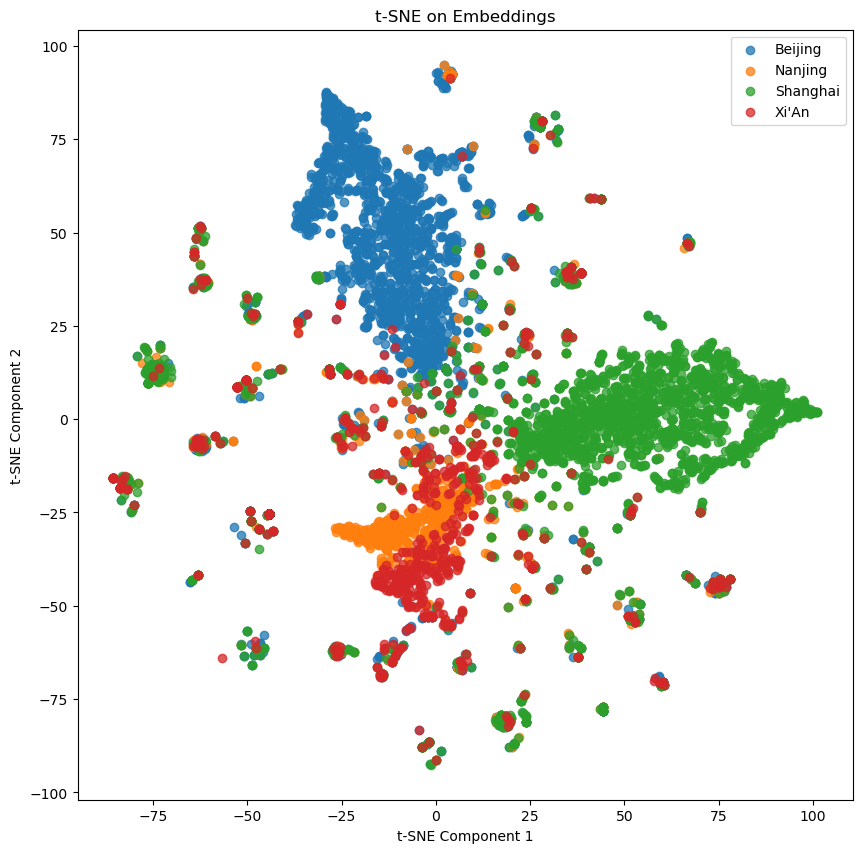

In [62]:
# Plot the t-SNE results
fig, ax = plt.subplots(figsize=(10, 10))
for l in labels.unique():
    ax.scatter(embeddings_2d[labels == l, 0], embeddings_2d[labels == l, 1], label=list(full_loader.dataset.label_mapping.keys())[l], alpha=0.75)
ax.set_title('t-SNE on Embeddings')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.legend()

plt.show()

# Downstream classification with SVM

In [63]:
# Initialize the SVM classifier
svm_classifier = LinearSVC(class_weight='balanced')

# Train the SVM classifier on the embeddings and labels
svm_classifier.fit(embeddings.detach().numpy(), labels.numpy())

# Make predictions on the training data
train_predictions = svm_classifier.predict(embeddings.detach().numpy())

print(classification_report(labels.numpy(), train_predictions))
print(f1_score(labels.numpy(), train_predictions, average='macro'))

              precision    recall  f1-score   support

           0       0.71      0.85      0.78      3233
           1       0.62      0.51      0.56      1074
           2       0.83      0.73      0.78      2793
           3       0.51      0.43      0.46       776

    accuracy                           0.72      7876
   macro avg       0.67      0.63      0.65      7876
weighted avg       0.72      0.72      0.72      7876

0.6451904314679806


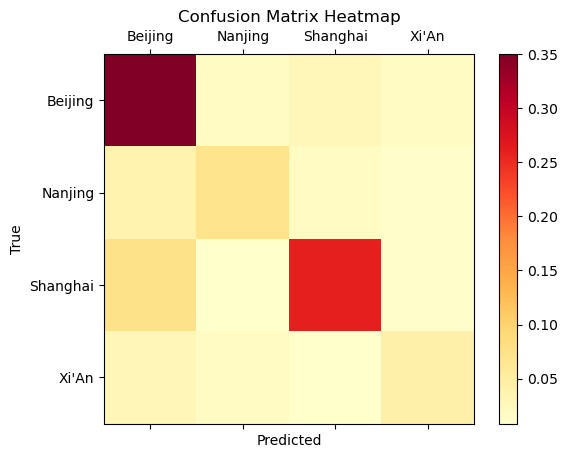

In [64]:
conf_matrix = np.zeros((len(np.unique(labels)), len(np.unique(labels))))
for i, j in zip(labels.numpy(), train_predictions):
    conf_matrix[i, j] += 1

fig, ax = plt.subplots()
cax = ax.matshow(conf_matrix/conf_matrix.sum(), cmap='YlOrRd')
fig.colorbar(cax)
plt.xticks(ticks=np.arange(4), labels=full_loader.dataset.label_mapping.keys())
plt.yticks(ticks=np.arange(4), labels=full_loader.dataset.label_mapping.keys())
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix Heatmap')
plt.show()

# Similarities

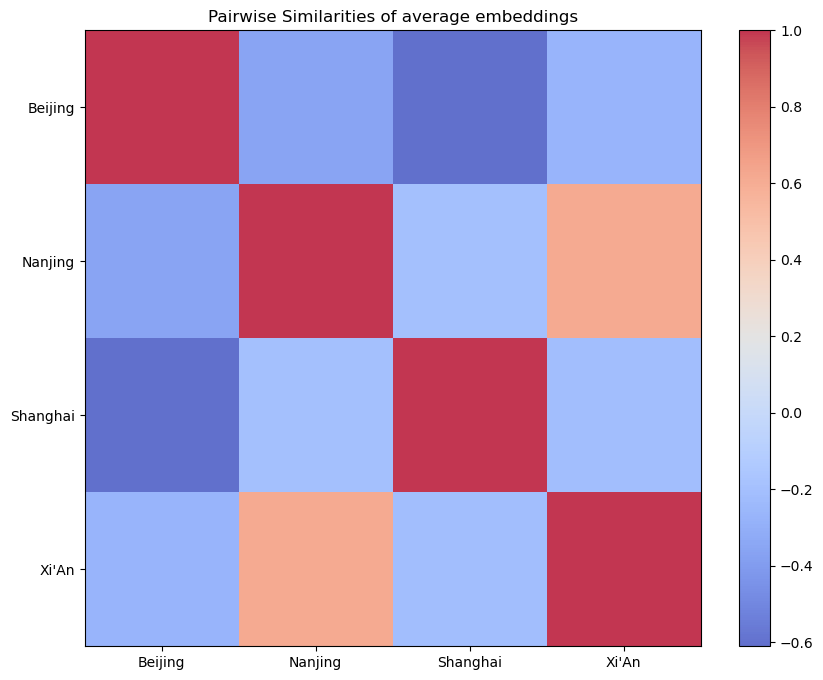

In [65]:
emb_df = pd.DataFrame(embeddings)
emb_df["label"] = labels
avg_emb = emb_df.groupby("label").mean()

# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(avg_emb)
# Compute the Euclidean distance matrix
# similarity_matrix = 1-euclidean_distances(avg_emb)

# Create a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap='coolwarm', alpha=0.8)
plt.colorbar()
plt.xticks(ticks=np.arange(len(avg_emb.index)), labels=full_loader.dataset.label_mapping.keys())
plt.yticks(ticks=np.arange(len(avg_emb.index)), labels=full_loader.dataset.label_mapping.keys())
plt.title('Pairwise Similarities of average embeddings')

plt.show()